In [33]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

from QODE import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr


In [34]:
# df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
df = pd.read_csv('./irregularly_sampled_data.csv')

In [35]:
columns = ['Open', 'High', 'Low', 'Close']

In [36]:
data = df.filter(columns)
dataset = data.values

In [37]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [38]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [39]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [40]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [41]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [42]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        # Ensure proper dimensions
        if len(X.shape) == 2:
            X = X.unsqueeze(0)  # Add batch dimension
        
        output = model(X)
        
        # Ensure output and target have same dimensions
        if len(output.shape) != len(y.shape):
            output = output.squeeze()
        
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # Ensure proper dimensions
            if len(X.shape) == 2:
                X = X.unsqueeze(0)
            
            output = model(X)
            
            # Ensure output and target have same dimensions
            if len(output.shape) != len(y.shape):
                output = output.squeeze()
            
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [43]:
from QODE import ShallowRegressionPeepholeLSTM

In [44]:
from QODE import ShallowRegressionQuantumODELSTM

In [45]:
from QODE import ShallowRegressionPeepholeLSTM
learning_rate = 0.01
num_hidden_units = 16

Qmodel = ShallowRegressionPeepholeLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    # n_qubits=7,
    # num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

In [46]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 1473


In [47]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.05078181625168443
Test loss: 0.0031324148608002853
Execution time 0.9550182819366455
Epoch 1
---------
Train loss: 0.0030112363379657258
Test loss: 0.001589274875405364
Execution time 0.9332451820373535
Epoch 2
---------
Train loss: 0.0020442910752446358
Test loss: 0.0011688082063839391
Execution time 0.8862159252166748
Epoch 3
---------
Train loss: 0.001144272326247911
Test loss: 0.0007366424098581553
Execution time 0.9479594230651855
Epoch 4
---------
Train loss: 0.0009421580934041667
Test loss: 0.00045744270585744055
Execution time 1.0145790576934814
Epoch 5
---------
Train loss: 0.0006858128395063245
Test loss: 0.0006847280705079905
Execution time 1.0679616928100586
Epoch 6
---------
Train loss: 0.0005429779949970942
Test loss: 0.0005063153442695094
Execution time 1.0453226566314697
Epoch 7
---------
Train loss: 0.00048482022025414707
Test loss: 0.0007099405564336476
Execution time 0.9944431781768799
Epoch 8
---------
Train lo

In [48]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

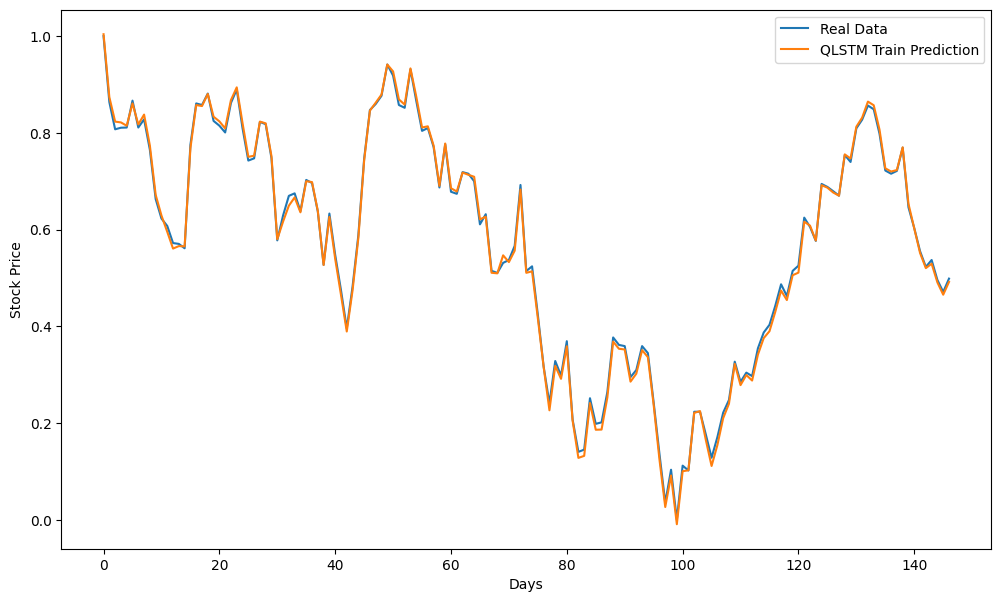

In [49]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

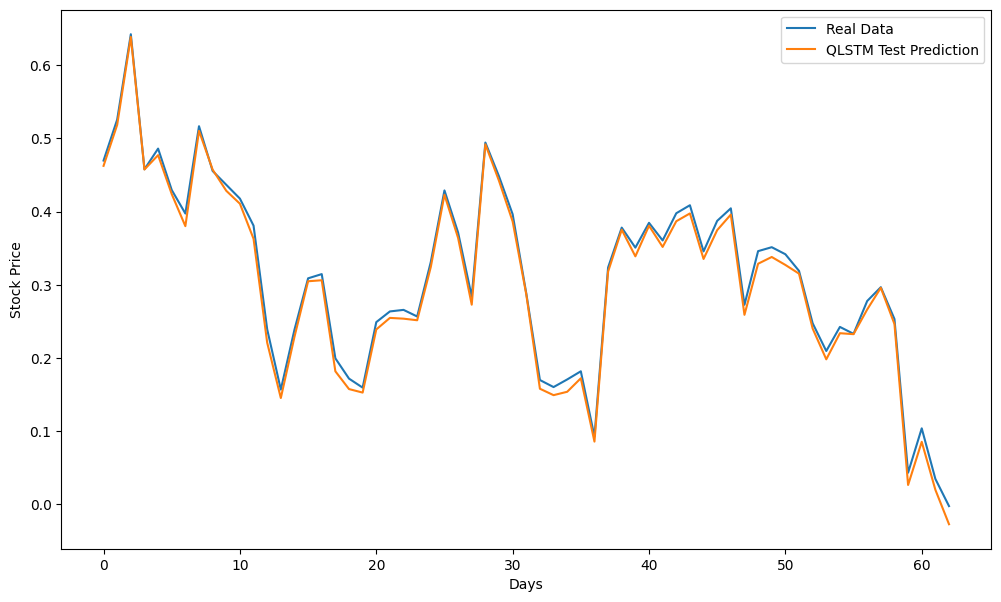

In [50]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Close"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend() 
plt.show()

In [51]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.0080307960656682
Test RMSE: 0.01076109921162592


Train RMSE: 0.01466425742167859
Test RMSE: 0.0140778726403129

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

# Calculate metrics for train data
train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
train_mae = mean_absolute_error(df_train["Close"], df_train["Model Forecast"])
# Avoid division by zero in MAPE calculation
train_mape = np.mean(np.abs((df_train["Close"] - df_train["Model Forecast"]) / np.maximum(np.abs(df_train["Close"]), 1e-10))) * 100

# Calculate metrics for test data
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
test_mae = mean_absolute_error(df_test["Close"], df_test["Model Forecast"])
# Avoid division by zero in MAPE calculation
test_mape = np.mean(np.abs((df_test["Close"] - df_test["Model Forecast"]) / np.maximum(np.abs(df_test["Close"]), 1e-10))) * 100

# Print all metrics
print("Training Data Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.2f}%")
print("\nTest Data Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

Training Data Metrics:
RMSE: 0.0080
MAE: 0.0068
MAPE: 63239871.15%

Test Data Metrics:
RMSE: 0.0108
MAE: 0.0095
MAPE: 20.33%


In [53]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 1.0
Test accuracy: 1.0


In [54]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")

In [55]:
import yfinance as yf

# High-frequency trading data
symbols = ['BTC-USD', 'ETH-USD', 'AAPL', 'GOOGL']
interval = '30m'  # 1-minute data
period = '7d'    # Last 7 days

data = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data[symbol] = ticker.history(period=period, interval=interval)

In [56]:
type(data)

dict

In [57]:
data

{'BTC-USD':                                    Open          High           Low  \
 Datetime                                                              
 2025-03-18 00:00:00+00:00  84033.265625  84033.265625  83825.140625   
 2025-03-18 00:30:00+00:00  83765.265625  83817.726562  83727.875000   
 2025-03-18 01:00:00+00:00  83799.546875  83902.390625  83268.015625   
 2025-03-18 01:30:00+00:00  83354.203125  83354.203125  83044.351562   
 2025-03-18 02:00:00+00:00  83164.070312  83440.992188  83134.398438   
 ...                                 ...           ...           ...   
 2025-03-24 05:30:00+00:00  86866.828125  86976.679688  86866.828125   
 2025-03-24 06:00:00+00:00  86907.156250  87242.593750  86907.156250   
 2025-03-24 06:30:00+00:00  87005.546875  87162.875000  86923.765625   
 2025-03-24 07:00:00+00:00  87127.539062  87163.007812  86947.625000   
 2025-03-24 07:30:00+00:00  86947.242188  86947.242188  86789.203125   
 
                                   Close      Volum

In [58]:
import pandas as pd

In [59]:
df = pd.DataFrame(data)

print(df)

ValueError: If using all scalar values, you must pass an index